
# Background
The article compares the performance of a set of classic sorting algorithms when implemented in Python. Included in the comparison are: Insertion sort, Merge sort, Heapsort and Quicksort. All these algorithms are comparison sorts which can be used on any data which has a well defined order and implements the `<` Python operator.

## Insertion sort

Insertion sort is a simple iterative sorting algorithm which can be implemented in <10 lines of code. It operates in-place with $O(1)$ additional memory use. In the best case, when the input is already sorted, no swaps are needed and runtime complexity is $O(n)$. In the worst case, when the input is reverse sorted, each of the `n` comparisons must move the entire remaining list, giving $O(n^2)$ runtime. The average runtime is also $O(n^2)$, making it not efficient for large arrays.
 
Due to low number of operations per element and a simple memory access pattern, it performs well on small sized arrays. Therefore several sorting algorithms switch over to use insertion sort for small arrays. An example is Timsort in CPython.

## Merge sort

Merge sort is a sorting algorithm based on divide-and-conquer: the array to sort is recursively divided into smaller parts until hitting the base case of a trivially sorted array (one element). A merge step then combines pairs of sub-arrays into bigger sorted sub-arrays until the entire array has been sorted.

Because the algorithm always divides the subproblems in two the best, average and worst-case runtime is given by the recurrence $T(n) = 2T(n/2) + n$, which is $O(n \lg n)$.
The basic implementation requires O(n) extra space for storing the temporary sub-array pairs.

The divide-and-conquer approach with mostly-independent data access makes merge sort very suitable for parallel processing.


## Heapsort

Heapsort works by dividing the input into a sorted and unsorted region, and iteratively growing the sorted region by extracing the largest value of the unsorted region. To do this efficiently, a maximum heap is used as as the underlying datastructure.

The heap can be constructed in-place in the input array, only requiring O(1) additional space.
Building the initial heap takes $O(n)$ time and each of the n extractions of largest value takes $O(n \log n)$ giving a worst, average and best case runtime of $O(n \log n)$.

Heapsort is not a stable sort: values that compare equally may move relative to eachother. The memory access pattern is spread throughout the entire array, which can lead to reduced performance due to poor cache utilization.

## Quicksort

Quicksort is also a divide-and-conquer type method. However, the choice of subproblems depends on the input data.
Good choices split the problems relatively evenly, reaching the $T(n) = 2T(n/2) + n$ recurrence of merge sort and $O(n \lg n)$ in best and average cases. However in bad cases, either previously sorted data, reverse sorted or identical, one side of the recursion tree consists only of 1 item, and performance drops to $O(n^2)$.

Quicksort tends to be faster than merge-sort (and heapsort) in the best-case.

Much work has been done on alternative variants of Quicksort which address the bad-case performance. One approach is to randomize the choice of pivot, or to use an estimate of the data input median. To eliminate the problem with identical values one can separate values into three groups instead of two: values less than the pivot, values equal to the pivot, and values greater than the pivot.

Introsort is an algorithm based on Quicksort which switches to heapsort when detecting bad-case subproblems.

## Summary of expected execution times

| Algorithm | Best | Average | Worst |
|------|------|------|------|
| Insertion sort |	$n$ | $n^{2}$ | $n^{2}$ |
| Merge sort | $n\log ⁡n$ | $n\log ⁡n$ | $n\log ⁡n$ |
| Heapsort | $n \log ⁡n$ | $n\log n$ | $n\log n$ |
| Quicksort |	$n\log n$ | $n\log n$ |	$n^{2}$ |



# Methods

The code for the algorithms tested as well as the benchmarking and result visualization code is provided inline.
The latest version of the Jupyter notebook used can be found at https://github.com/jonnor/datascience-master/blob/master/inf221/termpaper/Sorting.ipynb


In [97]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
import random
import time
import os
import sys
import timeit
import statistics

import numpy
import pandas
import string
import hypothesis.strategies

## Synthetic test data

Random data, identical data, sorted and reverse sorted data is expected to trigger worst/best/average case of the various algorithms. Both strings and integer numbers are used for testing and benchmarking.

In [70]:
def random_integers(length, number_range=30000000):
    r = number_range
    return [random.randint(-r, r) for _ in range(length)]

def random_floats(length, number_range=30000000):
    r = number_range
    return [random.uniform(-r, r) for _ in range(length)]
    
def random_numpy(length):
    return numpy.random.random(length)

def random_strings(length, stringlength=20):
    t = hypothesis.strategies.text(alphabet=string.printable, average_size=stringlength)
    return [ t.example() for _ in range(length) ]

def identical_strings(length, val=None):
    if val is None:
        val = random_strings(1)[0]
    return [ val for _ in range(length) ]

def identical_integers(length, val=None):
    if val is None:
        val = random.randint(0, 100000)
    return [ val for _ in range(length) ]

def ascending_integers(length, start=0):
    return [ start + i for i in range(length) ]

def descending_integers(length):
    return list(reversed(ascending_integers(length)))

input_data_types = [
    random_integers,
    random_strings,
    ascending_integers,
    descending_integers,
    identical_integers,
    identical_strings,
]

## Real-life data collection
Real-life data is likely to contain a mix of quasi-random, identical and sorted runs of values. The filenames and file sizes of file on the filesystem is collected as an example of such data.

In [71]:
file_sizes = []
file_names = []
for root, dirs, files in os.walk('/'):
    file_names += files
    for f in files:
        try:
            s = os.path.getsize(os.path.join(root, f))
            file_sizes.append(s)
        except PermissionError:
            pass
        except FileNotFoundError:
            pass
        except Exception as e:
            print('Unhandled Exception', e.__name__, str(e))
    file_sizes += sizes

assert len(file_names) > 10e3
assert sum(file_sizes) > 10e9
    
def real_filenames(length):
    return [ random.choice(file_names) for _ in range(length) ]

def real_filesizes(length):
    return [ random.choice(file_sizes) for _ in range(length) ]

input_data_types += [
    real_filesizes,
    real_filenames,
]

## Correctness

The correctness of the algorithms is checked by comparing results against the `sorted` function provided in Python.


In [4]:
def test_sort_with_data(sort, data_generator, examples=50, **kwargs):
    for t in range(examples): 
        data = data_generator(**kwargs)
        expected = sorted(data)
        out = data # in-place sorting
        sort(out)
        assert list(out) == expected, "{} != {}".format(out, expected)
    
def test_sort(sort, N=10):
    test_sort_with_data(sort, random_strings, length=N)
    test_sort_with_data(sort, random_integers, length=N)
    test_sort_with_data(sort, random_numpy, length=N)
    return 'tests passed'

def python_sort(data):
    data.sort()
    return None
        
test_sort(python_sort)

'tests passed'

## Insertion sort

Based on the pseudo-code provided chapter of <cite data-cite="Corm_Intr_2009">(Cormen et al, 2009)</cite>.

In [5]:
def insertion_sort(s):
    for i in range(1, len(s)):
        val = s[i]
        j = i - 1
        while j >= 0 and s[j] > val:
            s[j+1] = s[j]
            j = j - 1
        s[j+1] = val
    return s

test_sort(insertion_sort)

'tests passed'

## Merge sort

Non-sentinel version of pseudo-code provided in Chapter 2.3.1 of <cite data-cite="Corm_Intr_2009">(Cormen et al, 2009)</cite>.

In [96]:
def merge_check_empty(arr, start, mid, end):
    """Merge arr[start:mid] with arr[mid:end]"""
    left = arr[start:mid+1].copy()
    right = arr[mid+1:end+1].copy()
    l = 0
    r = 0
    left_length = len(left)
    right_length = len(right)
    for a in range(start, end+1):
        if not l < left_length:
            # left has been exhausted, fill remaining right
            arr[a] = right[r]
            r += 1
        elif not r < right_length:
            # right has been exhausted, fill remaining left
            arr[a] = left[l]
            l += 1
        elif left[l] <= right[r]:
            arr[a] = left[l]
            l += 1
        else:
            arr[a] = right[r]
            r += 1

def _merge_sort_check(arr, start, end):
    if start < end:
        mid = int((start + end) / 2)
        _merge_sort_check(arr, start, mid)
        _merge_sort_check(arr, mid+1, end)
        merge_check_empty(arr, start, mid, end)
    return arr

def mergesort(arr):
    return _merge_sort_check(arr, 0, len(arr)-1)

test_sort(mergesort)

'tests passed'

## Heapsort

Iterative version of pseudo-code provided in Chapter 6 of <cite data-cite="Corm_Intr_2009">(Cormen et al, 2009)</cite>.

In [7]:
def max_heapify_iterative(H, length, top):
    p = top
    while True:
        l = 2*p + 1
        r = 2*p + 2
        largest = p
        if l < length and H[l] > H[largest]:
            largest = l
        if r < length and H[r] > H[largest]:
            largest = r
        if largest != p:
            H[largest], H[p] = H[p], H[largest]
            p = largest
        else:
            break

def build_max_heap_iterative(A, length):
    H = A
    for i in range(length//2, -1, -1):
        max_heapify_iterative(H, length, i)
    return H

def heapsort(A):
    length = len(A)
    build_max_heap_iterative(A, length)
    for i in range(length-1, 0, -1):
        A[0], A[i] = A[i], A[0]
        length -= 1
        max_heapify_iterative(A, length, 0)

test_sort(heapsort)

'tests passed'

## Quicksort
 
Based on pseudocode from Chapter 7 <cite data-cite="Corm_Intr_2009">(Cormen et al, 2009)</cite>.

Note that this uses a simplified pivot selection compared to the original Quicksort paper. This is often called Lomuto partitioning.

In [8]:
def partition(A, low, high):
    pivot = A[high]
    i = low-1
    for j in range(low, high):
        if A[j] <= pivot:
            i += 1
            A[i], A[j] = A[j], A[i]

    if A[high] < A[i+1]:
        A[i+1], A[high] = A[high], A[i+1]
    return i+1

def _quicksort(A, low, high):
    if low < high:
        pivot = partition(A, low, high)
        _quicksort(A, low, pivot-1)
        _quicksort(A, pivot+1, high)
    
def quicksort(A):
    return _quicksort(A, 0, len(A)-1)

test_sort(quicksort, N=50)

'tests passed'

## Quicksort compiled with Numba
Python, like any other interpreted language, is known to have a good amount of overhead for compute-intensive tasks like sorting. Therefore we also test one algorithm using <cite data-cite="Numba">(Numba)</cite>, a just-in-time compilation framework for Python based on LLVM.

Functions that are marked with the `numba.jit` decorator gets compiled to native code on first execution. Numba will attempt to specialize the function by introspecting the types of the function arguments.

Quicksort was chosen because it is the algorithm that is expected to be fastest (in average case).

In [9]:
import numba
@numba.jit()
def partition_numba(A, low, high):
    pivot = A[high]
    i = low-1
    for j in range(low, high):
        if A[j] <= pivot:
            i += 1
            A[i], A[j] = A[j], A[i]

    if A[high] < A[i+1]:
        A[i+1], A[high] = A[high], A[i+1]
    return i+1

@numba.jit()
def _quicksort_numba(A, low, high):
    if low < high:
        pivot = partition_numba(A, low, high)
        _quicksort_numba(A, low, pivot-1)
        _quicksort_numba(A, pivot+1, high)

@numba.jit()
def quicksort_numba(A):
    return _quicksort_numba(A, 0, len(A)-1)

test_sort(quicksort_numba, N=50)

'tests passed'

# Benchmarking

To get sufficient statistics each sorting operation is repeated many times, and a number of independent runs are performed.

Because the sorting algorithms operate in-place, the input data must be copied to avoid pollution between the runs. The time taken by the copy step is removed from the results.

In [110]:
def benchmark_sort(sort, data, attempts=3):
    """Return the number of seconds it takes to sort @data.
    Best of @attempts, averaged over N repititions such that collection time is >0.2sec"""
    copytimer = timeit.Timer('data.copy()', globals=locals()) 
    ncopies, copytime = copytimer.autorange()
    copytime = copytime/ncopies

    timer = timeit.Timer('sort(data.copy())', globals=locals())
    ntimes, firsttime = timer.autorange()
    times = [firsttime] + timer.repeat(attempts-1, ntimes)
    best = (min(times) / ntimes) - copytime
    return best

## Tested system configuration

The benchmarks were performed on a low-end ultraportable laptop.

* Arch Linux, updated as of 3. December 2017
* Linux kernel 4.13.12-1
* CPython 3.6.3
* Intel Celeron N3050@1.60GHz
* 2GB RAM

All measurements were made while on connected to main power, with CPU temperature always under 70 degrees Celcius.

## Benchmark utilities
Some utility functions to more easily compare different combinations of algorithms, data types and input lengths (N) 

In [142]:
inefficient_sorts = { insertion_sort }
efficient_sorts = { heapsort, quicksort, mergesort }
custom_sorts = inefficient_sorts | efficient_sorts
native_sorts = { python_sort, quicksort_numba }
all_sorts = inefficient_sorts | efficient_sorts | native_sorts

def benchmark_data_comparison(data_generator, max_n=8192, algorithms=None, logstep=2, progress_cb=None):
    if algorithms is None:
        algorithms = custom_sorts | { python_sort }
    
    N = [ logstep**i for i in range(0, int(math.log(max_n, logstep)+1)) ]
    
    inputs = [ data_generator(n) for n in N ]
    series = { 'N': N }
    for func_idx, func in enumerate(algorithms):
        name = func.__name__
        series[name] = []
        for input_idx, i in enumerate(inputs):
            series[name].append(benchmark_sort(func, i))            
            if progress_cb:
                i_progress = (input_idx+1)/len(inputs)
                a_progress = (func_idx+1)/len(algorithms)
                progress_cb(a_progress, i_progress)

    return pandas.DataFrame(series)

def benchmark_data_versus_algorithms(data_types=None, max_n=None, algorithms=None, progress_cb=None):
    if data_types is None:
        data_types = input_data_types
    results = {}
    
    for idx, data_source in enumerate(data_types):
        def progress(a, b):
            t = (idx+1)/len(data_types)
            if progress_cb:
                progress_cb(t, a, b)

        df = benchmark_data_comparison(data_source, algorithms=algorithms, max_n=max_n, progress_cb=progress)
        name = data_source.__name__
        results[name] = df
    return results

def plot_data_versus_algorithms(results, ymax=None, figsize=(16, 22)):
    if ymax is None:
        ylim = None
    else:
        ylim = (0, ymax)
    
    columns = 2 if len(results) >= 2 else 1
    fig, axes = plt.subplots(nrows=math.ceil(len(results.items())/2), ncols=columns)
    if len(results) == 1:
        axes = [ [ axes ] ]
    elif len(results) == 2: 
        axes = [ axes ]
    for idx, res in enumerate(results.items()):
        name, df, = res
        col, row = idx % 2, idx // 2
        title = name.replace('_', ' ')
        legend = idx == 0
        ax = df.plot(x='N', ax=axes[row][col], legend=legend, figsize=figsize, title=title, ylim=ylim)
        ax.set_xlabel("Number of items (N)")
        ax.set_ylabel("Execution time [s]")

    return fig

def print_progress(a, b, c):
    print("{:05.1f}% {:05.1f}% {:05.1f}%".format(a*100, b*100, c*100), end="\r")

# Results

## Sorting algorithms on different input data

In [154]:
data_vs_algorithms = benchmark_data_versus_algorithms(max_n=1024, progress_cb=print_progress); 

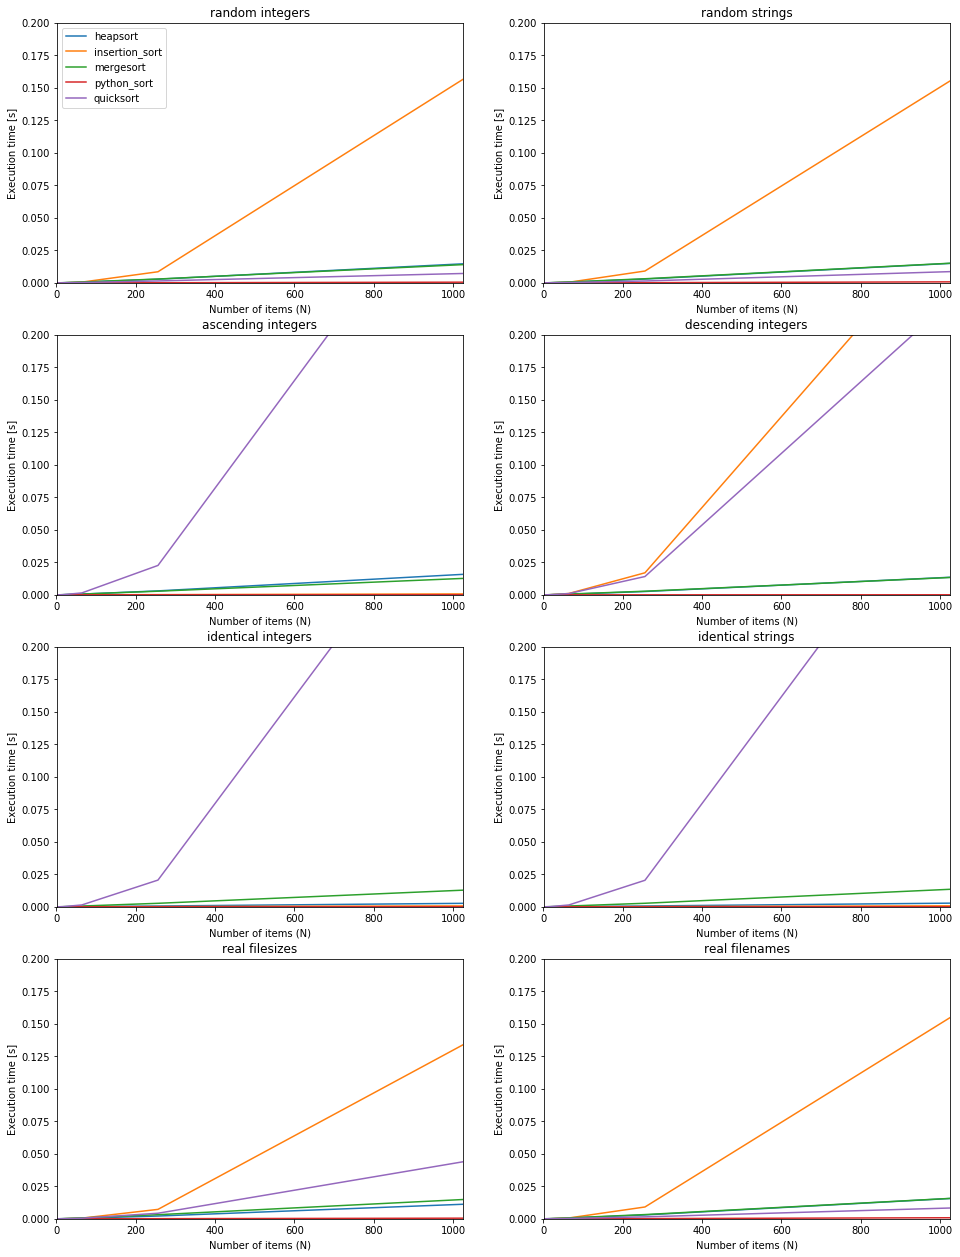

In [156]:
plot_data_versus_algorithms(data_vs_algorithms, ymax=0.20);

## Efficient algorithm comparisons
Isolating out the $O(n \log n)$ algorithms to compare them in more detail

In [159]:
large_inputs = [ random_integers ]
large_n = benchmark_data_versus_algorithms(algorithms=efficient_sorts|{python_sort}, max_n=22000, data_types=large_inputs, progress_cb=print_progress)

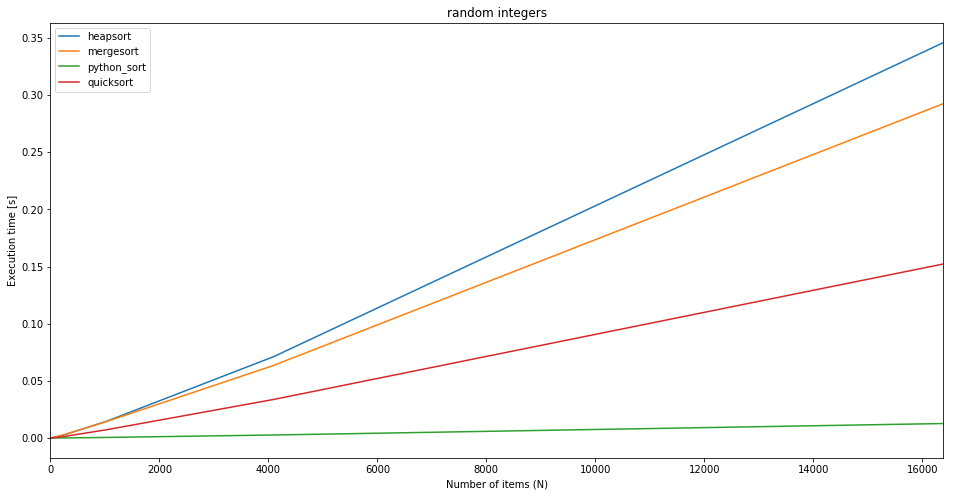

In [160]:
plot_data_versus_algorithms(large_n, ymax=None, figsize=(16, 8));

## numba.jit quicksort()
How much of a difference can it make?

In [150]:
numba_inputs = [random_integers, random_strings, identical_integers, real_filesizes]
numba_jit = benchmark_data_versus_algorithms(algorithms= { quicksort } | native_sorts, max_n=1024, data_types=numba_inputs, progress_cb=print_progress)

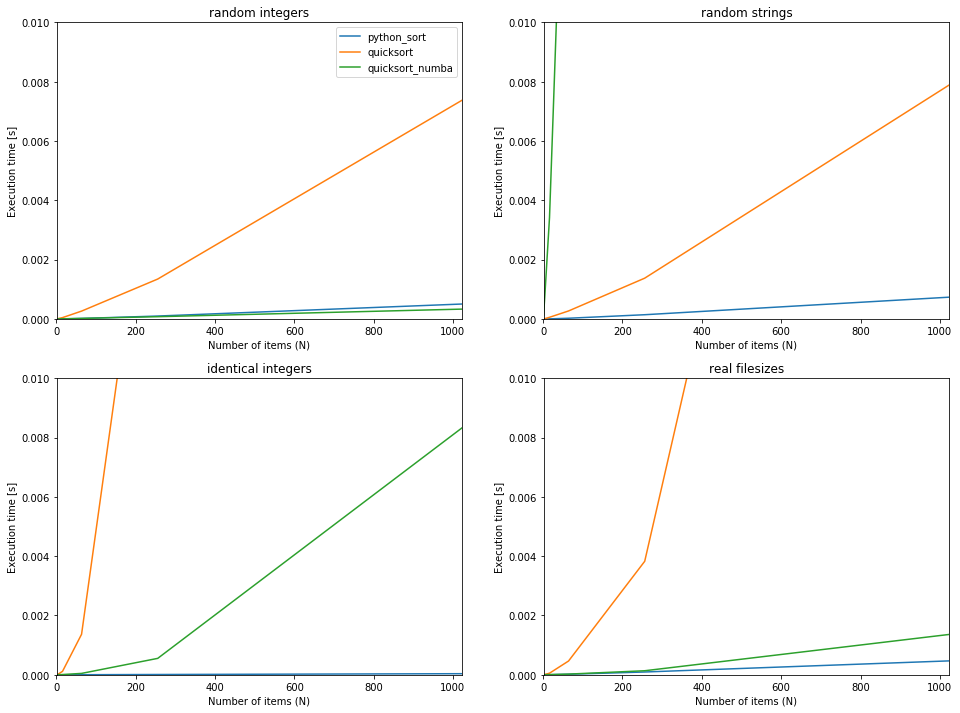

In [153]:
plot_data_versus_algorithms(numba_jit, ymax=0.01, figsize=(16, 12));

# Discussion


## Insertion sort
Insertion sort shows $O(N^2)$ scaling on both random data and on the real data, which is mostly random.
On identical values or integers already sorted ascending gives good performance. It is very near the Python sort() $O(n \log n)$, despite not being implemented in C, which supports a $O(n)$ complexity.

## Heapsort & Merge sort

Heapsort and mergesort show a consistent performance for all input types, $O(n \log n)$.
The performance differences between the two are generally small with mergesort performing slightly better. But for identical values heapsort outperforms mergesort significantly.

## Quicksort

Quicksort is fastest for the uniform random data, hitting its best-case runtime of $O(n \log n)$. However,
for already sorted data and identical values degrades to $O(n^2)$.

Quicksort also performs best on the quasi-random file names. But on file sizes it is beaten by both heapsort and mergesort. This is probably because the file size data contains a non-trivial of identical (or sorted) data, where quicksort performs horribly. 


## Data distribution more important than data type
Both the random string/integer and the identical string/integer benchmarks show the same patterns, with only a constant factor 3-5 difference between them at N=1000. However changing the distribution patterns gives hugely different results, because the complexity class changes.

##  Large differences even within same complexity class 

When comparing the efficient algorithms with $O(n \log n)$ complexity we see that there can still be large differences. The implemented Heapsort is around 3x slower than Quicksort.


## Performance versus Python reference

All the algorithms implemented in pure Python were very slow compared to Python built-in sort(), even in the best case. The fastest algorithm, Quicksort was over 10x slower.


## Numba speedups
When using Numba the slowdown versus Python sort() was completely eliminated for random integers. In fact the code is slightly faster by some 5-10%. This is a really promising result, considering that no changes had to be made to the algorithm, just adding one decorator.

However for random strings the results were insanely bad, facing slowdowns of 100x versus the pure Python code. The reason for this is was not investigated. Regardless of the reason, it does highlight that when using a JIT the results can be unpredictable and caution must be taken to ensure that it actually improves the performance.

On identical or partly identical data the $O(N^2)$ complexity of Quicksort means it still cannot compete. It is possible that an improved quicksort (Introsort) or a Timsort style combination of mergesort and insertionsort could have beaten Python sort() also in this case.

# Conclusions

Experimental results correspond well with theoretical asymptotic runtime estimates. We can see how some algorithms like insertion sort or quicksort perform well really well for some data, and bad for other data.

Comparisons with the built-in CPython sort() make it clear that it is a huge disadvantage to implement sorting in pure Python. However, JIT compilation with Numba shows promise as a very easy-to-use approach with the potential to practically eliminate this performance disadvantage.

Further work could be to implement an efficient all-round sorting algorithm in Python with Numba, and do a wider performance comparison, including against low-level languages like C++ or Rust.